In [9]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models ,layers
from PIL import Image
import os
import shutil

Specifying Image Size, Batch Size, Epochs, Channels

Image_Size = 256
Batch_Size = 64
Channels = 3
Epochs = 50

In [11]:
Image_Size = 256
Batch_Size = 64
Channels = 3
Epochs = 50

Loading Dataset

In [16]:
df = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/data",
    shuffle = True,
    image_size = (Image_Size, Image_Size),
    batch_size = Batch_Size
)

Found 1311 files belonging to 4 classes.


In [17]:
classes = df.class_names
classes

['glioma', 'meningioma', 'notumor', 'pituitary']

In [18]:
len(df)

21

In [19]:
for image_batch,label_batch in df.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())

(64, 256, 256, 3)
[1 0 3 2 3 1 0 2 1 3 3 0 0 3 3 2 1 2 0 1 2 2 2 2 2 2 0 0 2 0 3 3 0 0 3 2 3
 3 3 1 0 2 2 2 2 3 2 0 3 1 2 1 1 3 0 2 2 0 1 0 3 2 1 2]


DATA VISUALISATION

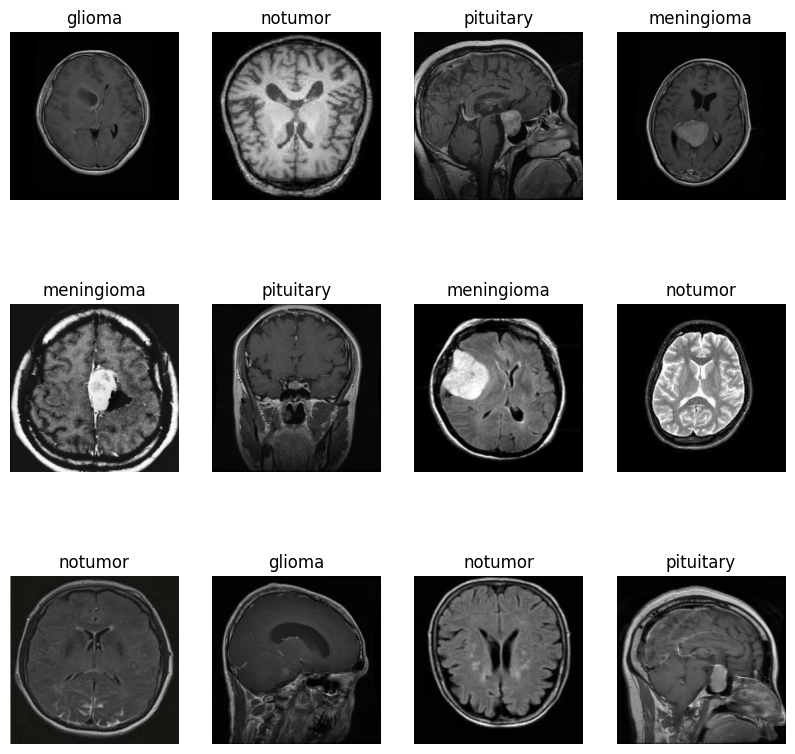

In [22]:
plt.figure(num=10, figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(classes[label_batch[i]])
        plt.axis("off")

Train Test Split
80% --> Training,
10% --> Validation,
10% --> Testing

In [29]:
def dataset_get_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=42)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [30]:
train_ds, val_ds, test_ds = dataset_get_partitions_tf(df)

In [31]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

16
2
3


Shuffling Data

In [32]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

Resize and Rescale Layer

In [33]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(Image_Size, Image_Size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

Data Augmentation Layer

In [34]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

Model Building

In [35]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 200x 200 with 3 bytes color
    # The first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a dense layer
    tf.keras.layers.Flatten(),
    # 128 neuron in the fully-connected layer
    tf.keras.layers.Dense(128, activation='relu'),
    # 5 output neurons for 5 classes with the softmax activation
    tf.keras.layers.Dense(4, activation='softmax')
])

Model Summary

In [36]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 64)       

Setting up Learning Rate and Optimizer

In [37]:
# Implement learning rate scheduling
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

Compiling the Model

In [38]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

Setting up Early Stopping

In [39]:
# Implement early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

Training Model

In [40]:
# Train the model with more epochs
history = model.fit(
    train_ds,
    epochs=Epochs,  # Increase the number of epochs
    batch_size=Batch_Size,
    verbose=1,
    validation_data=val_ds,
    callbacks=[early_stopping]
)

Epoch 1/50
16/16 [==============================] - 98s 6s/step - loss: 6.9811 - accuracy: 0.3066 - val_loss: 1.3245 - val_accuracy: 0.3750
Epoch 2/50
16/16 [==============================] - 73s 5s/step - loss: 1.1774 - accuracy: 0.4844 - val_loss: 1.0095 - val_accuracy: 0.5781
Epoch 3/50
16/16 [==============================] - 72s 5s/step - loss: 0.8611 - accuracy: 0.6621 - val_loss: 0.7025 - val_accuracy: 0.6953
Epoch 4/50
16/16 [==============================] - 76s 5s/step - loss: 0.6946 - accuracy: 0.7197 - val_loss: 0.5582 - val_accuracy: 0.7812
Epoch 5/50
16/16 [==============================] - 72s 5s/step - loss: 0.5339 - accuracy: 0.7881 - val_loss: 0.4294 - val_accuracy: 0.8438
Epoch 6/50
16/16 [==============================] - 75s 5s/step - loss: 0.5222 - accuracy: 0.7861 - val_loss: 0.4856 - val_accuracy: 0.8047
Epoch 7/50
16/16 [==============================] - 75s 5s/step - loss: 0.4447 - accuracy: 0.8203 - val_loss: 0.3466 - val_accuracy: 0.8516
Epoch 8/50
16/16 [==

Evaluating Model on test data

In [41]:
scores = model.evaluate(test_ds)

3/3 [==============================] - 9s 1s/step - loss: 0.1002 - accuracy: 0.9635


Plotting Loss and Accuracy Curve

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

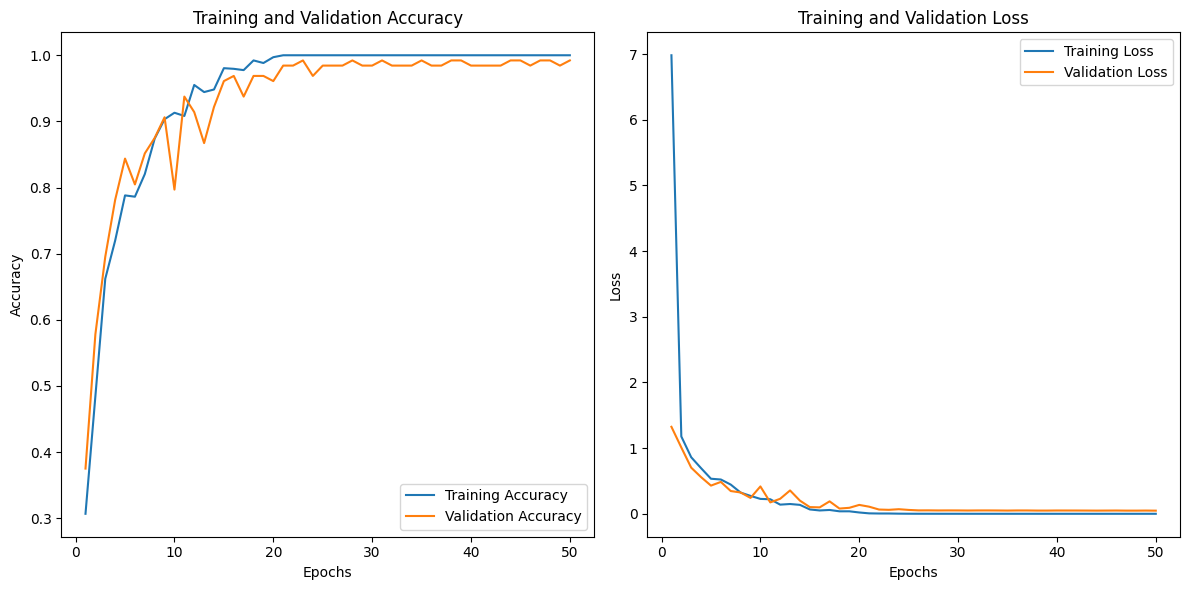

In [43]:
# Plotting the training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(acc) + 1), acc, label='Training Accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting the training and validation loss
plt.subplot(1, 2, 2)
plt.plot(range(1, len(loss) + 1), loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Looking at Predictions

2/2 [==============================] - 2s 1s/step


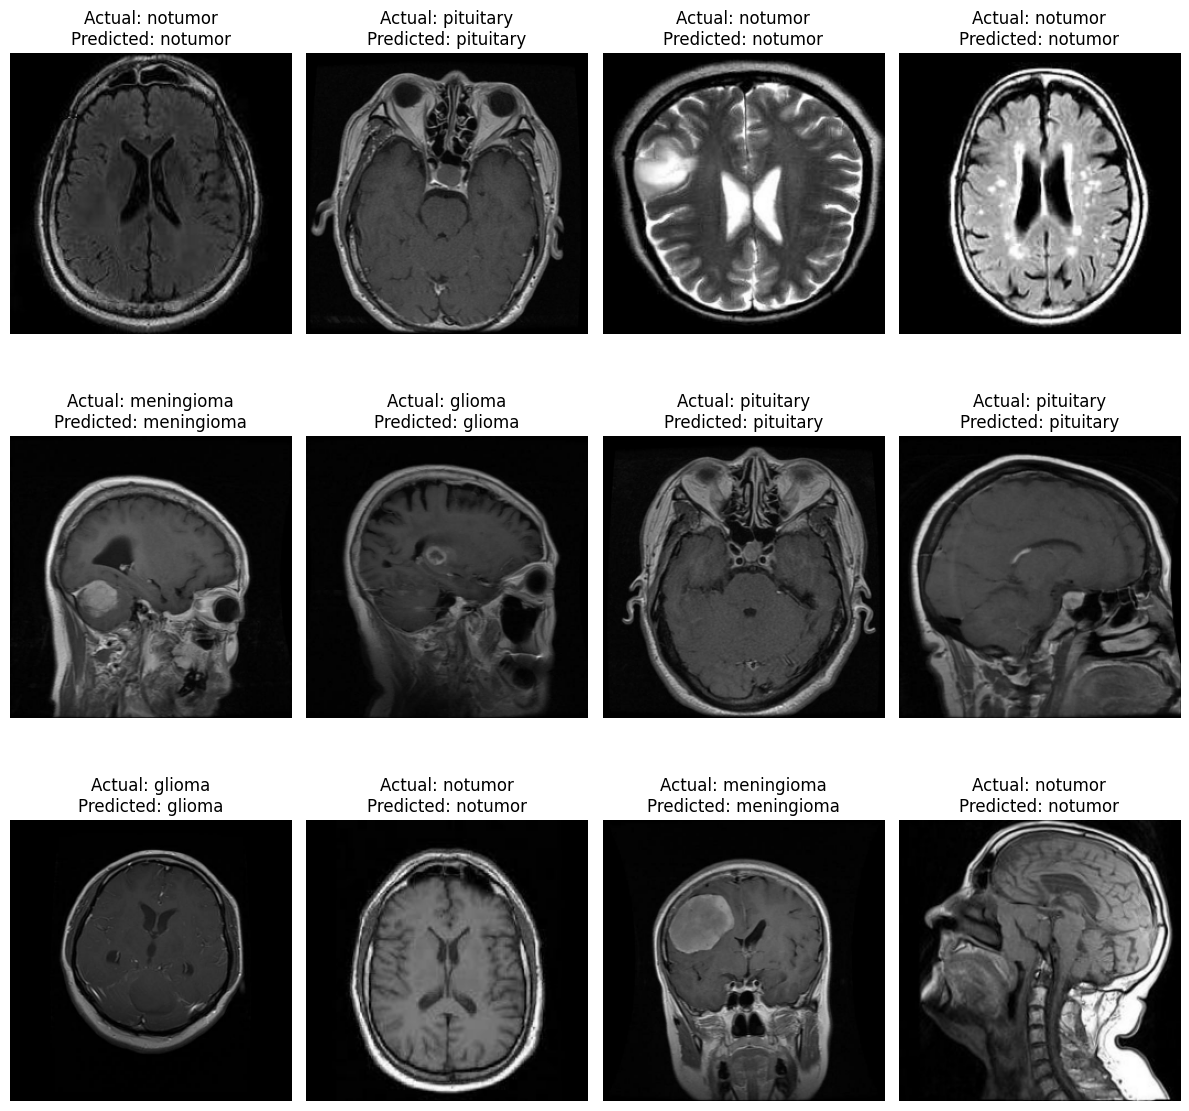

In [44]:
# Get some random samples from the test dataset
sample_images = []
sample_labels = []
for images, labels in test_ds.take(1):
    sample_images = images.numpy()
    sample_labels = labels.numpy()

# Make predictions on the random samples
predictions = model.predict(sample_images)

# Visualize random samples with actual and predicted labels
num_samples = len(sample_images)
num_rows = 3
num_cols = 4
plt.figure(figsize=(12, 12))
for i in range(min(num_samples, num_rows * num_cols)):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(sample_images[i].astype("uint8"))
    actual_label = classes[sample_labels[i]]
    predicted_label = classes[np.argmax(predictions[i])]
    title = f"Actual: {actual_label}\nPredicted: {predicted_label}"
    plt.title(title)
    plt.axis("off")

plt.tight_layout()
plt.show()